In [1]:
import openapi_client
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import os
import re
import zipfile

from google.cloud import bigquery

In [2]:
# Configure API key authorization: api_key
# More Info: https://api.namsor.com/namsor/faces/viewapikey.xhtml
configuration = openapi_client.Configuration()
configuration.api_key['X-API-KEY'] = 'YOUR_API_KEY' # Replace with your API KEY. 

# create an instance of the API class
api_instance = openapi_client.PersonalApi(openapi_client.ApiClient(configuration))

# Prediction of Country of Origin

In this notebook we will predict the country of origin for the names using the NamSor API. For this purpose we will use two different methods available in the NamSor API: `Diaspora` and `Origin`.

The first method (`Diaspora`) is more accurate and requires three different inputs for the prediction: **First Name**, **Last Name**, and **Country of Residence**. However, since we don't have access to the **Country of residence** for all of our names, in order to have the country of origins' precidtion for all the names, we use the second method (`Origin`), which requires only two inputs (**First Name**, **Last Name**).

# 1. Predicting the Country of Origin (Using `Origin` method)

## 1.1. Loading raw (first name, last name) pairs

**Note:** For running this section you need to first download the `gs://uspto-data/final_dataset/raw_name_pairs.csv` file and add it under the following directory: `./data_namsor/`

In [20]:
# Loading the names
df_names = pd.read_csv('./data_namsor/raw_name_pairs.csv', low_memory=False)
print('Number of rows: {:,}'.format(df_names.shape[0]))
df_names.head()

Number of rows: 3,229,517


,name_first,name_last
0,TADAMICHI,HATTORI
1,VLADIMIR,POUTCHKOV
2,CORINA,KLOSS
3,SHAHBAZ,ABBAS
4,YUDI,GAO


In [21]:
### Preprocessing the names
# Handling NaN values
df_names.name_first[df_names.name_first.isna()] = ''
df_names.name_last[df_names.name_last.isna()] = ''
# Replacing special characters
df_names.name_first = df_names.name_first.str.replace(r'[\*\@\#\!\%\^\&\(\)\$\.\,]+', '', regex=True)
df_names.name_last = df_names.name_last.str.replace(r'[\*\@\#\!\%\^\&\(\)\$\.\,]+', '', regex=True)

## 1.2. Requesting the NamSor API for the prediction

In [80]:
### Resuming from the last processed name
N = df_names.shape[0]
# Finding the lastest available index, for continuing the request
files_list = [root+'/'+file for root, directory, files in os.walk('./data_namsor') for file in files if re.search(r'^(names\_origin\_check\_\d+)\.csv$', file)]
idx_start = -1
for file in files_list:
    idx_start = max(idx_start, pd.read_csv(file, usecols=['index'])['index'].max())
idx_start += 1
# batch size anf number of request to be saved in each step
batch_size = 1000
check_point_steps = 50000
error_log = []
# create an instance of the API class
api_instance = openapi_client.PersonalApi(openapi_client.ApiClient(configuration))
df_origin = pd.DataFrame(columns=['index','first_name', 'last_name', 'country_origin', 'country_origin_alt', 
                                  'score', 'sub_region_origin', 'top_region_origin'])

In [ ]:
# Requesting from NamSor API for the `Origin` prediction
start_time = time.perf_counter()
pbar = tqdm(total=(N-idx_start))

for i in range(idx_start, N, batch_size):
    names_list = [dict(firstName=x, lastName=y) for k, (x, y) in df_names.iloc[i:i+batch_size, :].iterrows()]
    batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(names_list)
    try:
        api_response = api_instance.origin_batch(batch_first_last_name_in=batch_first_last_name_in)
        for j, dic in enumerate(api_response.personal_names):
            data = pd.DataFrame(dict(index=i+j,first_name=[dic.first_name], last_name=[dic.last_name], 
                                     country_origin=[dic.country_origin], country_origin_alt=[dic.country_origin_alt], 
                                     score=[dic.score], sub_region_origin=[dic.sub_region_origin], 
                                     top_region_origin=[dic.top_region_origin]))
            df_origin = df_origin.append(data, ignore_index=True)
            pbar.update(1)
    except:
        error_log.append(dict(range_idx=(i,i+batch_size), names_list=names_list, df_portion=df_names.iloc[i:i+batch_size,:]))
        data = pd.DataFrame(dict(index=[idx for idx in range(i, i+batch_size)], 
                                 first_name=[np.nan for idx in range(i,i+batch_size)], 
                                 last_name=[np.nan for idx in range(i,i+batch_size)], 
                                 country_origin=[np.nan for idx in range(i,i+batch_size)], 
                                 country_origin_alt=[np.nan for idx in range(i,i+batch_size)], 
                                 score=[np.nan for idx in range(i,i+batch_size)], 
                                 sub_region_origin=[np.nan for idx in range(i,i+batch_size)], 
                                 top_region_origin=[np.nan for idx in range(i,i+batch_size)]))
        df_origin = df_origin.append(data, ignore_index=True)
        pbar.update(batch_size)
        
    if (i+batch_size)%check_point_steps==0:
        df_origin.to_csv('./data_namsor/names_origin_check_{}.csv'.format(i//check_point_steps), encoding='UTF-8',index=False)
        df_origin = pd.DataFrame(columns=['index','first_name', 'last_name', 'country_origin', 
                                          'country_origin_alt', 'score', 'sub_region_origin', 'top_region_origin'])
df_origin.to_csv('./data_namsor/names_origin_check_{}.csv'.format(i//check_point_steps+1), encoding='UTF-8',index=False)
pbar.close()
stop_time = time.perf_counter()
print('\nTotal processing time was {:,} hours and {:,} mintues!'.format((stop_time-start_time)//3600 + 32, 
                                                                        ((stop-start_time)//60)%60))
print('Total number of errors: {:,}'.format(len(error_log)))

## 1.3. Iterating Over the Failed Requests

In [165]:
### Concatenating the results into one dataframe
files_list = sorted([root+'/'+file for root, directory, files in os.walk('./data_namsor') 
                     for file in files if re.search(r'^(names\_origin\_check\_\d+)\.csv$', file)])
pbar = tqdm(total=len(files_list))
# Concatenating all files into one dataframe
df_origin_f = pd.DataFrame(columns=['index','first_name', 'last_name', 'country_origin', 'country_origin_alt',
                                    'score', 'sub_region_origin', 'top_region_origin'])
for file in files_list:
    df_ = pd.read_csv(file, low_memory=False)
    df_origin_f = pd.concat([df_origin_f, df_], axis=0, ignore_index=True)
    pbar.update(1)
pbar.close()

df_origin_f = df_origin_f.sort_values(by=['index']).reset_index(drop=True)
# Verifying the results
print('Total number of rows: {:,}'.format(df_origin_f.shape[0]))
df_origin_f.head()

Total number of rows: 3,229,517


,index,first_name,last_name,country_origin,country_origin_alt,score,sub_region_origin,top_region_origin
0,0,TADAMICHI,HATTORI,JP,NE,12.904708,Eastern Asia,Asia
1,1,VLADIMIR,POUTCHKOV,RU,UA,3.506230,Eastern Europe,Europe
2,2,CORINA,KLOSS,CH,DE,0.739209,Western Europe,Europe
3,3,SHAHBAZ,ABBAS,PK,IR,8.670143,Southern Asia,Asia
4,4,YUDI,GAO,CN,ID,2.130741,Eastern Asia,Asia


In [36]:
### Finding the failed requests
df_names[df_names.index.isin(df_origin_f[df_origin_f.drop('index',axis=1).isna().all(axis=1)]['index'])]\
                .rename({'name_first':'name_first_o', 'name_last':'name_last_o'}, axis=1).head()

,name_first_o,name_last_o
133000,TIM,AYERS
133001,MASAYUKI,ICHIMONJI
133002,PRZEMYSLAW,RUPNOWSKI
133003,WATLER,THEODORE
133004,BENJAMIN,WELANDER


In [148]:
### Predicting the failed requests
files_list = sorted([root+'/'+file for root, directory, files in os.walk('./data_namsor') for file in files 
                     if re.search(r'^(names\_origin\_check\_\d+)\.csv$', file)])
batch_size = 10
error_log = []
df_remained = df_names[df_names.index.isin(df_origin_f[df_origin_f.drop('index',axis=1).isna().all(axis=1)]['index'])]\
                .rename({'name_first':'name_first_o', 'name_last':'name_last_o'}, axis=1)
pbar = tqdm(total=df_remained.shape[0])

for file in files_list:
    df_origin = pd.read_csv(file)
    df_ = df_remained[df_remained.index.isin(df_origin['index'])]
    columns = df_origin.columns
    for i in range(0,df_.shape[0], batch_size):
        names_list = [dict(firstName=x, lastName=y) for k, (x, y) in df_.iloc[i:i+batch_size].iterrows()]
        idx = df_.iloc[i:i+batch_size].index
        idx_orig = df_origin[df_origin['index'].isin(idx)].index
        batch_first_last_name_in = openapi_client.BatchFirstLastNameIn(names_list)
        try:
            api_response = api_instance.origin_batch(batch_first_last_name_in=batch_first_last_name_in)
            data = pd.DataFrame(columns=columns)
            for j, dic in enumerate(api_response.personal_names):
                data = pd.concat([data, 
                                  pd.DataFrame(dict(index=idx[j],first_name=[dic.first_name], last_name=[dic.last_name], 
                                                    country_origin=[dic.country_origin], 
                                                    country_origin_alt=[dic.country_origin_alt], 
                                                    score=[dic.score], sub_region_origin=[dic.sub_region_origin], 
                                                    top_region_origin=[dic.top_region_origin]))], axis=0, ignore_index=True)
                pbar.update(1)
            data = data.set_index(idx_orig)
            df_origin.loc[df_origin['index'].isin(idx)] = data

        except:
            error_log.append(dict(range_idx=(i,i+batch_size), names_list=names_list, 
                                  df_portion=df_names.iloc[i:i+batch_size,:]))
    # Save back the modified file
    df_origin.to_csv(file, encoding='UTF-8',index=False)
pbar.close()

100%|█████████▉| 657980/658000 [4:21:20<00:00, 41.96it/s]


## 1.4. Creating the Dataframe containing the `Origin` predicted country of origins

In [29]:
df_names = pd.read_csv('./data_namsor/raw_name_pairs.csv', low_memory=False)
print('Number of rows: {:,}'.format(df_names.shape[0]))
df_names.head(2)

Number of rows: 3,229,517


,name_first,name_last
0,TADAMICHI,HATTORI
1,VLADIMIR,POUTCHKOV


In [30]:
### Concatenating the final results into one dataframe
files_list = sorted([root+'/'+file for root, directory, files in os.walk('./data_namsor') for file in files 
                     if re.search(r'^(names\_origin\_check\_\d+)\.csv$', file)])
pbar = tqdm(total=len(files_list))
# Concatenating all files into one dataframe
df_origin_f = pd.DataFrame(columns=['index','first_name', 'last_name', 'country_origin', 'country_origin_alt',
                                    'score', 'sub_region_origin', 'top_region_origin'])
for file in files_list:
    df_ = pd.read_csv(file, low_memory=False)
    df_origin_f = pd.concat([df_origin_f, df_], axis=0, ignore_index=True)
    pbar.update(1)
pbar.close()

100%|██████████| 65/65 [01:15<00:00,  2.22s/it]


In [31]:
df_origin_f = df_origin_f.rename(columns={'first_name':'name_first_har', 'last_name':'name_last_har'})
df_origin_f.head(2)

,index,name_first_har,name_last_har,country_origin,country_origin_alt,score,sub_region_origin,top_region_origin
0,0,TADAMICHI,HATTORI,JP,NE,12.904708,Eastern Asia,Asia
1,1,VLADIMIR,POUTCHKOV,RU,UA,3.506230,Eastern Europe,Europe


In [32]:
df_origin_f = df_origin_f.sort_values(by=['index']).reset_index(drop=True)

df_origin_f = pd.concat([df_names, df_origin_f], axis=1)
columns = df_origin_f.columns
df_origin_f = df_origin_f[columns[np.r_[2:3,0:2,3:10]]]
df_origin_f.head(2)

,index,name_first,name_last,name_first_har,name_last_har,country_origin,country_origin_alt,score,sub_region_origin,top_region_origin
0,0,TADAMICHI,HATTORI,TADAMICHI,HATTORI,JP,NE,12.904708,Eastern Asia,Asia
1,1,VLADIMIR,POUTCHKOV,VLADIMIR,POUTCHKOV,RU,UA,3.506230,Eastern Europe,Europe


In [35]:
df_origin_f.to_csv('./data_namsor/origin_processed.csv', encoding='utf-8', index=False)

# 2. Predicting the Country of Origin (Using `Diaspora` method)

## 2.1. Loading raw (first name, last name, country codes) triples

**Note:** For running this section you need to first download the `gs://uspto-data/final_dataset/raw_name_triples.csv` file and add it under the following directory: `./data_namsor/`

In [3]:
# Loading Names with country Codes
df_names = pd.read_csv('./data_namsor/raw_name_triples.csv', low_memory=False)
print('Number of rows: {:,}'.format(df_names.shape[0]))
df_names.head(2)

Number of rows: 3,836,819


,name_first,name_last,country_code
0,SARA,MARTINSEN,DK
1,MARIE,TURKINGTON,IE


In [4]:
### Preprocessing the names
# Handling NaN values
df_names.name_first[df_names.name_first.isna()] = ''
df_names.name_last[df_names.name_last.isna()] = ''
# Replacing special characters
df_names.name_first = df_names.name_first.str.replace(r'[\*\@\#\!\%\^\&\(\)\$\.\,]+', '', regex=True)
df_names.name_last = df_names.name_last.str.replace(r'[\*\@\#\!\%\^\&\(\)\$\.\,]+', '', regex=True)

df_names.head(2)

,name_first,name_last,country_code
0,SARA,MARTINSEN,DK
1,MARIE,TURKINGTON,IE


## 2.2. Requesting the NamSor API for the prediction

In [6]:
### Resuming the prediction from the last processed name
N = df_names.shape[0]
# Finding the lastest available index, for continuing the request
files = [root+'/'+file for root, directory, files in os.walk('./data_namsor/namesCountry_origin') for file in files 
         if re.search(r'^(namesCountry\_origin\_check\_\d+)\.csv$', file)]
idx_start = -1
for file in files:
    idx_start = max(idx_start, pd.read_csv(file, usecols=['indexing'])['indexing'].max())
idx_start += 1

# batch size anf number of request to be saved in each step
batch_size = 100
steps = 20000
error_log = []
# create an instance of the API class
api_instance = openapi_client.PersonalApi(openapi_client.ApiClient(configuration))
df_diasOrigin = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                      'ethnicity', 'ethnicity_alt', 'lifted', 'score'])

In [ ]:
# Requeting from NamSor API for the `Diaspora` prediction
start_time = time.perf_counter()
pbar = tqdm(total=(N-idx_start))

for i in range(idx_start, N, batch_size):
    df_iter = df_names.iloc[i:i+batch_size, :]
    namesCountry_list = [dict(firstName=x, lastName=y, countryIso2=z) for k, (x, y, z) in df_iter.iterrows()]
    batch_first_last_name_geo_in = openapi_client.BatchFirstLastNameGeoIn(namesCountry_list)
    try:
        api_response = api_instance.diaspora_batch(batch_first_last_name_geo_in=batch_first_last_name_geo_in)
        df_ = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                    'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
        for j, dic in enumerate(api_response.personal_names):
            data = pd.DataFrame(dict(indexing=df_iter.index[j],name_first=[dic.first_name], name_last=[dic.last_name], 
                                     country_code=df_iter.country_code.iloc[j], ethnicity=[dic.ethnicity], 
                                     ethnicity_alt=[dic.ethnicity_alt], lifted=[dic.lifted], score=[dic.score]))
            df_ = df_.append(data, ignore_index=False)
        df_diasOrigin = df_diasOrigin.append(df_, ignore_index=False)
        pbar.update(batch_size)
    except:
        error_log.append(dict(range_idx=(i,i+batch_size), namesCountry_list=namesCountry_list, 
                              df_portion=df_names.iloc[i:i+batch_size,:]))
        df_ = pd.DataFrame(dict(indexing=df_iter.index, name_first=df_iter.name_first,
                                name_last=df_iter.name_last, country_code= df_iter.country_code,
                                ethnicity=[np.nan for idx in range(i,i+batch_size)], 
                                ethnicity_alt=[np.nan for idx in range(i,i+batch_size)], 
                                lifted=[np.nan for idx in range(i,i+batch_size)], 
                                score=[np.nan for idx in range(i,i+batch_size)]))
        df_diasOrigin = df_diasOrigin.append(df_, ignore_index=True)
        pbar.update(batch_size)
        
    if (i+batch_size)%steps==0:
        df_diasOrigin.to_csv('./data_namsor/namesCountry_origin/namesCountry_origin_check_{:03d}.csv'.format(i//steps), 
                             encoding='UTF-8',index=False)
        df_diasOrigin = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                              'ethnicity', 'ethnicity_alt', 'lifted', 'score'])

df_diasOrigin.to_csv('./data_namsor/namesCountry_origin/namesCountry_origin_check_{:03d}.csv'.format(i//steps+1), 
                     encoding='UTF-8',index=False)
pbar.close()
stop_time = time.perf_counter()
print('\nTotal processing time was {:,} hours and {:,} mintues!'.format((stop_time-start_time)//3600, 
                                                                        ((stop_time-start_time)//60)%60))
print('Total number of errors: {:,}'.format(len(error_log)))

 11%|█         | 424300/3836819 [49:11<4:15:08, 222.91it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 1068400/3836819 [2:30:25<7:56:34, 96.82it/s]

## 2.3. Iterating Over the Failed Requests

In [3]:
### Concatenating the prediction results into one dataframe
files_list = sorted([root+'/'+file for root, directory, files in 
                     os.walk('./data_namsor/namesCountry_origin') for file in files 
                     if re.search(r'^(namesCountry\_origin\_check\_\d+)\.csv$', file)])

pbar = tqdm(total=len(files_list))
# Concatenating all files into one dataframe
df_names_origin = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                        'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
df_temp = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
for i, file in enumerate(files_list):
    df_ = pd.read_csv(file, low_memory=False)
    df_temp = pd.concat([df_temp, df_], axis=0, ignore_index=True)
    if i%20==0:
        df_names_origin = pd.concat([df_names_origin, df_temp], axis=0, ignore_index=True)
        df_temp = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                        'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
    elif i>= len(files_list)-1:
        df_names_origin = pd.concat([df_names_origin, df_temp], axis=0, ignore_index=True)
        df_temp = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                        'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
        print('Terminated!')
    pbar.update(1)
pbar.close()

df_names_origin.head(2)

100%|██████████| 192/192 [00:30<00:00,  3.54it/s]

Terminated!


,indexing,name_first,name_last,country_code,ethnicity,ethnicity_alt,lifted,score
0,0,SARA,MARTINSEN,DK,Norwegian,Danish,True,1.856552
1,1,MARIE,TURKINGTON,IE,Irish,British,False,13.720753


In [5]:
### Requesting for `Diaspora` method for predicting the failed ones
# Getting the list of results' files
files_list = sorted([root+'/'+file for root, directory, files in 
                     os.walk('./data_namsor/namesCountry_origin') for file in files 
                     if re.search(r'^(namesCountry\_origin\_check\_\d+)\.csv$', file)])
batch_size = 1
error_log = []
df_remained = df_names_origin[(df_names_origin.country_code.notna())&
                              (df_names_origin[['ethnicity', 'ethnicity_alt', 'score']].isna().all(axis=1))]
pbar = tqdm(total=df_remained.shape[0])

for file in files_list:
    df_origin = pd.read_csv(file)
    df_remained = df_origin[(df_origin.country_code.notna())&
                            (df_origin[['ethnicity', 'ethnicity_alt', 'score']].isna().all(axis=1))]
    #columns = df_origin.columns
    for idx, row in df_remained.iterrows():
        names_list = [dict(firstName=row['name_first'], lastName=row['name_last'], countryIso2=row['country_code'])]
        #batch_first_last_name_geo_in = openapi_client.BatchFirstLastNameGeoIn(namesCountry_list)
        try:
            api_response = api_instance.diaspora(country_iso2=row['country_code'], first_name=row['name_first'], 
                                                 last_name= row['name_last'])
            data = pd.DataFrame(dict(indexing=row['indexing'],name_first=[row['name_first']], 
                                     name_last=[row['name_last']], country_code=[row['country_code']],
                                     ethnicity=[api_response.ethnicity], ethnicity_alt=[api_response.ethnicity_alt],
                                     lifted=[api_response.lifted], score=[api_response.score]), index=[idx])
            df_origin.loc[idx:idx] = data
            pbar.update(1)

        except:
            pbar.update(1)
            error_log.append(dict(range_idx=idx, names_list=names_list, df_portion=df_origin.loc[idx:idx]))
    # Save back the modified file
    df_origin.to_csv(file, encoding='UTF-8',index=False)
pbar.close()

100%|██████████| 5074/5074 [11:38<00:00,  7.81it/s]


In [3]:
### Concatenating the final results into one datafrmae
files_list = sorted([root+'/'+file for root, directory, files in 
                     os.walk('./data_namsor/namesCountry_origin') for file in files 
                     if re.search(r'^(namesCountry\_origin\_check\_\d+)\.csv$', file)])

pbar = tqdm(total=len(files_list))
# Concatenating all files into one dataframe
df_names_dias = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                      'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
df_temp = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
for i, file in enumerate(files_list):
    df_ = pd.read_csv(file, low_memory=False)
    df_temp = pd.concat([df_temp, df_], axis=0, ignore_index=True)
    if i%20==0:
        df_names_dias = pd.concat([df_names_dias, df_temp], axis=0, ignore_index=True)
        df_temp = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                        'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
    elif i>= len(files_list)-1:
        df_names_dias = pd.concat([df_names_dias, df_temp], axis=0, ignore_index=True)
        df_temp = pd.DataFrame(columns=['indexing','name_first', 'name_last', 'country_code', 
                                        'ethnicity', 'ethnicity_alt', 'lifted', 'score'])
        print('Terminated!')
    pbar.update(1)
pbar.close()

df_names_dias.head(2)

100%|██████████| 192/192 [00:29<00:00,  3.63it/s]

Terminated!


,indexing,name_first,name_last,country_code,ethnicity,ethnicity_alt,lifted,score
0,0,SARA,MARTINSEN,DK,Norwegian,Danish,True,1.856552
1,1,MARIE,TURKINGTON,IE,Irish,British,False,13.720753


## 2.4. Mapping the Diaspora Ethnicity to The Country Codes

In order to do this step, we mannualy went through the dispora ethnicity lists and assigned the most likely country to them.  

**Note:** Since the result of `Origin` method returns the origin in the format of country codes (*e.g.* FR for France, and not in the format of ethnicties, *e.g.* French ), performing this step will enable us to use both `.Ethnicity` and `.Origin` together.

**The result of the mapping can be loaded using the following code:**

In [4]:
# Loading the mapping
df_ = pd.read_csv('./data/ethnicity_country_map.csv', keep_default_na=False, na_values=' ')
display(df_.head(2))

,ethnicity,eth_country
0,Afghan,AF
1,Albanian,AL


In [5]:
# Mapping Ethnicity to their country names
df_names_dias = pd.merge(df_names_dias, df_, on=['ethnicity'], how='left')
df_names_dias.head(2)

,indexing,name_first,name_last,country_code,ethnicity,ethnicity_alt,lifted,score,eth_country
0,0,SARA,MARTINSEN,DK,Norwegian,Danish,True,1.856552,NO
1,1,MARIE,TURKINGTON,IE,Irish,British,False,13.720753,IE


## 2.5. Creating the Dataframe containing the `Dispora` predicted country of origins

In [201]:
### Loading the raw (unprocessed) Names with their country Codes
df_names = pd.read_csv('./data_namsor/raw_name_triples.csv', low_memory=False)
print('{:,}'.format(df_names.shape[0]))
df_names.head(2)

3,836,819


,name_first,name_last,country_code
0,SARA,MARTINSEN,DK
1,MARIE,TURKINGTON,IE


In [212]:
### Adding the unprocessed names to the prediction table
df_names_eth_f = pd.concat([df_names, df_names_dias.rename(columns={'country_code':'country_code_2'})], axis=1)
cols = df_names_eth_f.columns
df_names_eth_f = df_names_eth_f[cols[np.r_[3:4,0:3,4:6,7:12]]]
df_names_eth_f.head(2)

,indexing,name_first,name_last,country_code,name_first_har,name_last_har,ethnicity,ethnicity_alt,lifted,score,eth_country
0,0,SARA,MARTINSEN,DK,SARA,MARTINSEN,Norwegian,Danish,True,1.856552,NO
1,1,MARIE,TURKINGTON,IE,MARIE,TURKINGTON,Irish,British,False,13.720753,IE


In [213]:
# Saving the final results
#df_names_eth_f.to_csv('./data_namesor/diaspora_processed.csv', encoding='utf-8', index=False)

# 3. Visualizing the distribution of the Scores in "Diaspora" vs. "Origin" method

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import cm
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set(style="darkgrid", context='talk')

import pandas as pd
import numpy as np
from google.cloud import bigquery
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [6]:
df_names_origin = pd.read_csv('./data/origin_processed.csv', low_memory=False)
df_names_eth = pd.read_csv('./data/diaspora_processed.csv', low_memory=False)

display(df_names_origin.head(3))
display(df_names_eth.head(3))

,index,name_first,name_last,name_first_har,name_last_har,country_origin,country_origin_alt,score,sub_region_origin,top_region_origin
0,0,TADAMICHI,HATTORI,TADAMICHI,HATTORI,JP,NE,12.904708,Eastern Asia,Asia
1,1,VLADIMIR,POUTCHKOV,VLADIMIR,POUTCHKOV,RU,UA,3.506230,Eastern Europe,Europe
2,2,CORINA,KLOSS,CORINA,KLOSS,CH,DE,0.739209,Western Europe,Europe


,indexing,name_first,name_last,country_code,name_first_har,name_last_har,ethnicity,ethnicity_alt,lifted,score,eth_country
0,0,SARA,MARTINSEN,DK,SARA,MARTINSEN,Norwegian,Danish,True,1.856552,NO
1,1,MARIE,TURKINGTON,IE,MARIE,TURKINGTON,Irish,British,False,13.720753,IE
2,2,KJELL,JACOBSEN,NO,KJELL,JACOBSEN,Danish,Norwegian,False,25.175981,DK


In [53]:
df_p1 = df_names_origin[['country_origin','score']].rename(columns={'country_origin':'origin'}).copy()
df_p1['Method'] = 'Origin'
df_p2 = df_names_eth[['ethnicity','score']].rename(columns={'ethnicity':'origin'}).copy()
df_p2['Method'] = 'Dispora'
df_plot = pd.concat([df_p1, df_p2], axis=0, ignore_index=True)
df_plot.head(2)

,origin,score,Method
0,JP,12.904708,Origin
1,RU,3.506230,Origin


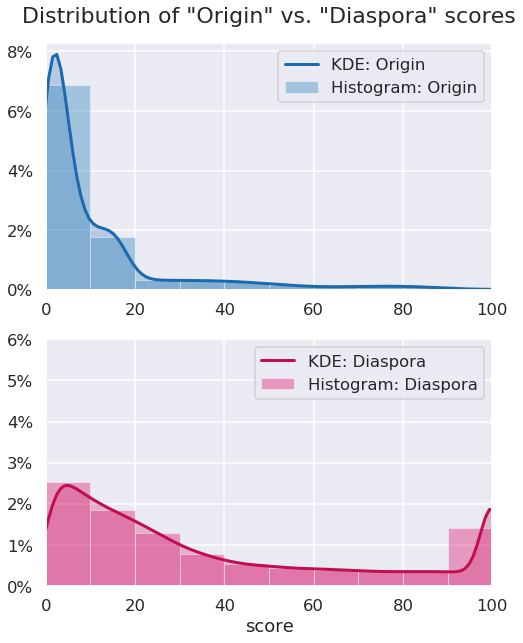

In [123]:
x1 = df_p1.score
x2 = df_p2.score
pal_1 = sns.color_palette("Blues", 8)
pal_2 = sns.color_palette("PuRd", 8)
fig, ax = plt.subplots(2, 1, figsize=(8,10))
g1 = sns.distplot(ax=ax[0], a=x1, bins=10, color='b', #axlabel='My axis', #label="Y",  
                 kde=True, hist=True, rug=False, vertical=False,
                 kde_kws={"color": pal_1.as_hex()[6], "lw": 3, "shade":True, "bw":2.5, "label": "KDE: Origin"},
                 hist_kws={"histtype": "barstacked", "linewidth": 1, "alpha": 0.4, "color": pal_1.as_hex()[5], "label":"Histogram: Origin"},)

g2 = sns.distplot(ax=ax[1], a=x2, bins=10, color='r', #axlabel='My axis', #label="Y",  
                 kde=True, hist=True, rug=False, vertical=False,
                 kde_kws={"color": pal_2.as_hex()[6], "lw": 3, "shade":True, "bw":2.5, "label": "KDE: Diaspora"},
                 hist_kws={"histtype": "barstacked", "linewidth": 1, "alpha": 0.4, "color": pal_2.as_hex()[5], "label":"Histogram: Diaspora"},)

ax[0].set_xlabel('')
ax[1].set_ylim((0.0,0.06))
ax[0].set_xlim((0,df_p1.score.max()))
ax[1].set_xlim((0,df_p2.score.max()))
ax[0].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax[1].yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
g1.set_title('Distribution of "Origin" vs. "Diaspora" scores', fontsize=22, pad=20)
#g2.set_title('', fontsize=19)
#g.set_ylabel('Counts', fontsize=18)
#g.set_xlabel('X axis', fontsize=18)
#g.set(xscale="log")
plt.show()

In [150]:
df_map = pd.read_csv('./data/country_code_iso2.csv', low_memory=False).rename(columns={'Name':'country', 'Code':'country_code'}).set_index('country_code')
code_dict = df_map.to_dict()['country']
df_map.head(2)

,country
country_code,
AF,Afghanistan
AX,Åland Islands


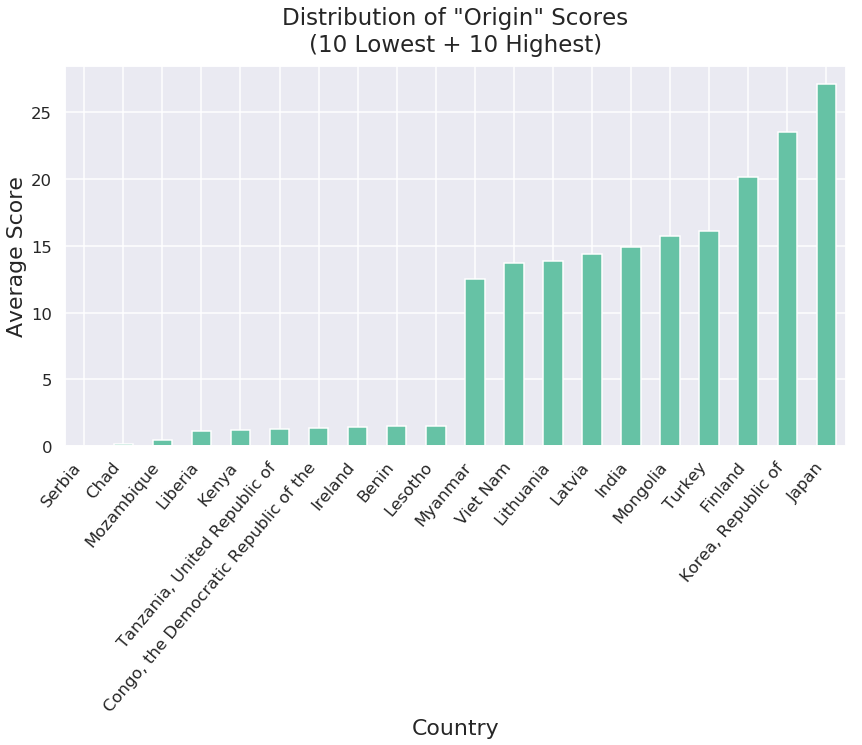

In [186]:
df_scores = df_names_origin.groupby('country_origin').agg({'score':'mean'}).sort_values(by=['score'])#.reset_index(drop=False)
df_scores = df_scores.loc[np.r_[df_scores.index[:10],df_scores.index[-10:]],:]
df_scores.index = df_scores.reset_index(drop=False).country_origin.replace(code_dict)

fig, ax = plt.subplots(1, 1, figsize=(14,7))
df_scores.plot(ax=ax, kind='bar', stacked=False, colormap='Set2')
ax.bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='right')
ax.set_xlabel('Country', fontsize=22)
ax.set_ylabel('Average Score', fontsize=22)
ax.set_title('Distribution of "Origin" Scores\n(10 Lowest + 10 Highest)', fontsize=23, pad=15)
ax.get_legend().remove()
#ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
#          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
plt.show()

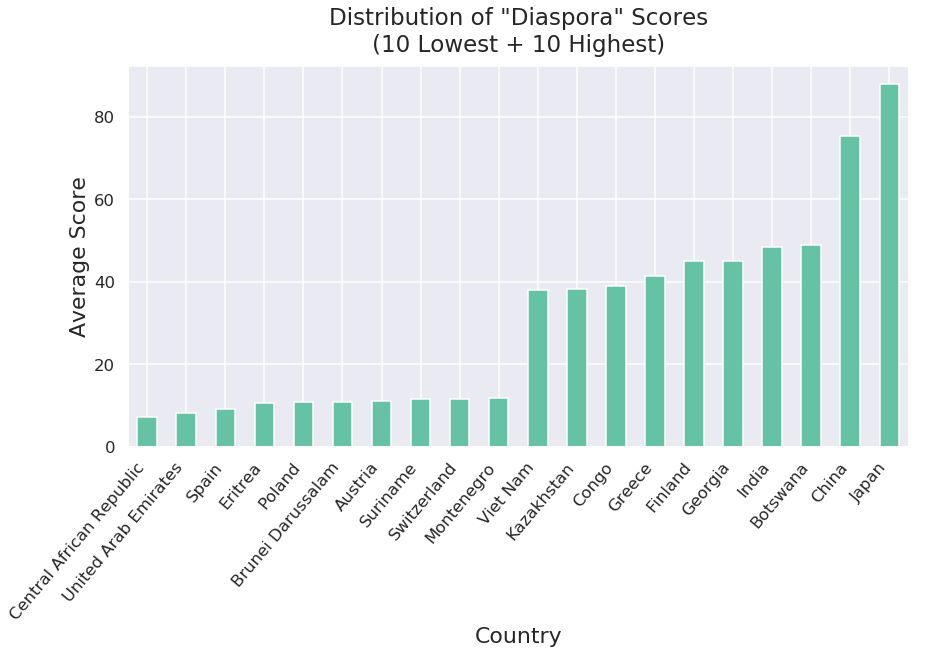

In [185]:
df_scores = df_names_eth.groupby('eth_country').agg({'score':'mean'}).sort_values(by=['score'])#.reset_index(drop=False)
df_scores = df_scores.loc[np.r_[df_scores.index[:10],df_scores.index[-10:]],:]
df_scores.index = df_scores.reset_index(drop=False).eth_country.replace(code_dict)

fig, ax = plt.subplots(1, 1, figsize=(14,7))
df_scores.plot(ax=ax, kind='bar', stacked=False, colormap='Set2')
ax.bar
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha='right')
ax.set_xlabel('Country', fontsize=22)
ax.set_ylabel('Average Score', fontsize=22)
ax.set_title('Distribution of "Diaspora" Scores\n(10 Lowest + 10 Highest)', fontsize=23, pad=15)
ax.get_legend().remove()
#ax.legend(#['First', 'Second', 'Third'], # you can send a list to change the legends
#          loc='center left', bbox_to_anchor=(1., 0.5)) # bbox_to_anchor is for putting legend outside the plot
plt.show()

# 4. Creating The final Names-Origin Dataset

In [80]:
print('{:,}\n{:,}'.format(df_names_origin.shape[0], df_names_eth.shape[0]))

3,229,517
3,836,819


In [81]:
# Loading "Origin" and "Diaspora" data
df_names_origin = pd.read_csv('./data_namsor/origin_processed.csv', low_memory=False).rename(columns={'index':'indexing'})
df_names_dias = pd.read_csv('./data_namsor/diaspora_processed.csv', low_memory=False)

# Removing duplicates
df_names_origin = df_names_origin.drop_duplicates(subset=['name_first', 'name_last'])
df_names_dias = df_names_dias.drop_duplicates(subset=['name_first', 'name_last', 'country_code'])

print('df_names_origin: (Origin Data)')
print('Nb. records: {:,}'.format(df_names_origin.shape[0]))
display(df_names_origin.head(3))

print('\ndf_names_eth: (Ethnicity Data)')
print('Nb. records: {:,}'.format(df_names_dias.shape[0]))
display(df_names_dias.head(3))

df_names_origin: (Origin Data)
Nb. records: 3,229,497


,indexing,name_first,name_last,name_first_har,name_last_har,country_origin,country_origin_alt,score,sub_region_origin,top_region_origin
0,0,TADAMICHI,HATTORI,TADAMICHI,HATTORI,JP,NE,12.904708,Eastern Asia,Asia
1,1,VLADIMIR,POUTCHKOV,VLADIMIR,POUTCHKOV,RU,UA,3.506230,Eastern Europe,Europe
2,2,CORINA,KLOSS,CORINA,KLOSS,CH,DE,0.739209,Western Europe,Europe



df_names_eth: (Ethnicity Data)
Nb. records: 3,836,801


,indexing,name_first,name_last,country_code,name_first_har,name_last_har,ethnicity,ethnicity_alt,lifted,score,eth_country
0,0,SARA,MARTINSEN,DK,SARA,MARTINSEN,Norwegian,Danish,True,1.856552,NO
1,1,MARIE,TURKINGTON,IE,MARIE,TURKINGTON,Irish,British,False,13.720753,IE
2,2,KJELL,JACOBSEN,NO,KJELL,JACOBSEN,Danish,Norwegian,False,25.175981,DK


According the "NamSor" response to our question regarding the metling-pot countries, we have the following flags for the melting countries:  

In [58]:
df_melt = pd.read_excel('./data/namsor_melting_pots.xlsx', sheet_name=0, header=0, keep_default_na=False, na_values=' ')\
            .rename(columns={'countryISO2': 'country_code', 'classifyingOrigin_Or_MeltingPot':'is_origin'})
print('Number of records: {:,}'.format(df_melt.shape[0]))
df_melt.head(2)

Number of records: 248


,country_code,is_origin
0,AF,True
1,AL,True


Another implication of this list is that the response of "Origin" class only contains countries which have a `True` flag in **"is_origin"** feature.  
We have double checked this with the response that we got from our dataset.

In [62]:
# Adding Name of the Countries
df_map = pd.read_csv('./data/country_code_iso2.csv', low_memory=False, keep_default_na=False, na_values=' ')\
           .rename(columns={'Name':'country', 'Code':'country_code'})
df_melt['country'] = df_melt.country_code.replace(df_map.set_index('country_code').to_dict()['country']).copy()
display(df_melt.head(2))

## Checking Whether there is any "False" flag in the response of "origin" class
# 1: we get the list of countries that we got from "origin" method
country_o = df_names_origin.country_origin.unique()
# 2: we check whether there any countries in this list with "False" flag
print('\n\nThe list of countries which have a "True" flag but could be found in the response of "origin" methos:')
df_melt[(df_melt.country_code.isin(country_o))&(df_melt.is_origin==False)]

,country_code,is_origin,country
0,AF,True,Afghanistan
1,AL,True,Albania




The list of countries which have a "True" flag but could be found in the response of "origin" methos:


,country_code,is_origin,country


The above result confirm our assumption.

**Now, we first load the names data:**

In [137]:
# Loading Names with country Codes
df_names = pd.read_csv('./data_namsor/raw_name_triples.csv', low_memory=False)
df_names= df_names.drop_duplicates()
print('Number of rows: {:,}'.format(df_names.shape[0]))

# Handling NaN values
df_names['name_first_har'] = df_names.name_first.copy()
df_names['name_last_har'] = df_names.name_last.copy()
df_names.name_first_har[df_names.name_first_har.isna()] = ''
df_names.name_last_har[df_names.name_last_har.isna()] = ''

# Replacing special characters
df_names.name_first_har = df_names.name_first_har.str.replace(r'[\*\@\#\!\%\^\&\(\)\$\.\,]+', '', regex=True)
df_names.name_last_har = df_names.name_last_har.str.replace(r'[\*\@\#\!\%\^\&\(\)\$\.\,]+', '', regex=True)

df_names = df_names.reset_index(drop=False).rename(columns={'index':'indexing'})
df_names.head(2)

Number of rows: 3,836,801


,indexing,name_first,name_last,country_code,name_first_har,name_last_har
0,0,SARA,MARTINSEN,DK,SARA,MARTINSEN
1,1,MARIE,TURKINGTON,IE,MARIE,TURKINGTON


**We split the names into three dataframes:**
1. `df_names_1` : Names that have a country code, which is a origin country
2. `df_names_2` : Names that have a country code, which is a melting-pot country
3. `df_names_3` : Names which have not a country code associated with them

In [138]:
# List of countries with "True" Flag
country_t = df_melt[df_melt.is_origin==True]['country_code']
# Splitting the data set
df_names_1 = df_names[(df_names.country_code.isin(country_t))&(df_names.country_code.notna())]
df_names_2 = df_names[(~df_names.country_code.isin(country_t))&(df_names.country_code.notna())]
df_names_3 = df_names[df_names.country_code.isna()]

# Double-checking the validity of the splitted dataframes
print('Sum of the records in the splitted dataframes: {:,}\tvs.\tNb. records in `df_names`: {:,}'
      .format(df_names_1.shape[0]+df_names_2.shape[0]+df_names_3.shape[0], df_names.shape[0]))

Sum of the records in the splitted dataframes: 3,836,801	vs.	Nb. records in `df_names`: 3,836,801


Now, for `df_names_1` and `df_names_3` we use results of `Origin` method as its country of origin. While for `df_names_2` we use the result of `Dispora` method.

In [139]:
#######################
# Merging `df_names_1`#
shape_ = df_names_1.shape[0]
df_names_1 = pd.merge(df_names_1, df_names_origin.drop(columns=['indexing', 'name_first_har', 'name_last_har', 'country_origin_alt',
                                                                'score','sub_region_origin', 'top_region_origin']), 
                      on=['name_first', 'name_last'], suffixes=('', '_2'))
print('Nb. records in `df_names_1`: \tBefore merging {:,}\tvs.\tAfter merging {:,}'.format(shape_, df_names_1.shape[0]))
#######################
# Merging `df_names_2`#
shape_ = df_names_2.shape[0]
df_names_2 = pd.merge(df_names_2, df_names_dias.drop(columns=['indexing', 'name_first_har', 'name_last_har', 'ethnicity',
                                                              'ethnicity_alt', 'lifted', 'score']).rename(columns={'eth_country':'country_origin'}), 
                      on=['name_first', 'name_last', 'country_code'], suffixes=('', '_2'))
print('Nb. records in `df_names_2`: \tBefore merging {:,}\tvs.\tAfter merging {:,}'.format(shape_, df_names_2.shape[0]))
#######################
# Merging `df_names_3`#
shape_ = df_names_3.shape[0]
df_names_3 = pd.merge(df_names_3, df_names_origin.drop(columns=['indexing', 'name_first_har', 'name_last_har', 'country_origin_alt',
                                                                'score','sub_region_origin', 'top_region_origin']), 
                      on=['name_first', 'name_last'], suffixes=('', '_2'))
print('Nb. records in `df_names_3`: \tBefore merging {:,}\t\tvs.\tAfter merging {:,}\n'.format(shape_, df_names_3.shape[0]))

display(df_names_1.head(2))
display(df_names_2.head(2))
display(df_names_3.head(2))

Nb. records in `df_names_1`: 	Before merging 1,776,959	vs.	After merging 1,776,959
Nb. records in `df_names_2`: 	Before merging 1,621,120	vs.	After merging 1,621,120
Nb. records in `df_names_3`: 	Before merging 438,722		vs.	After merging 438,722



,indexing,name_first,name_last,country_code,name_first_har,name_last_har,country_origin
0,0,SARA,MARTINSEN,DK,SARA,MARTINSEN,DK
1,1,MARIE,TURKINGTON,IE,MARIE,TURKINGTON,GB


,indexing,name_first,name_last,country_code,name_first_har,name_last_har,country_origin
0,5,JOSE,MALMONGE,BR,JOSE,MALMONGE,PT
1,7,YEW,MUI,SG,YEW,MUI,CN


,indexing,name_first,name_last,country_code,name_first_har,name_last_har,country_origin
0,1095,FRANK,KERNSTOCK,NaN,FRANK,KERNSTOCK,DE
1,6084,CORNELIUS,POWELL,NaN,CORNELIUS,POWELL,GB


In [140]:
# Concatenating the results together
df_origin_final = pd.concat([df_names_1, df_names_2, df_names_3], axis=0, ignore_index=True).sort_values(by=['indexing']).reset_index(drop=True)

print('Nb. records in the concatenated dataframe:\t\t{:,} \tvs.\nNb. records in the initial `df_names` dataframe:\t{:,}\n'
      .format(df_origin_final.shape[0], df_names.shape[0]))
df_origin_final.head(3)

Nb. records in the concatenated dataframe:		3,836,801 	vs.
Nb. records in the initial `df_names` dataframe:	3,836,801



,indexing,name_first,name_last,country_code,name_first_har,name_last_har,country_origin
0,0,SARA,MARTINSEN,DK,SARA,MARTINSEN,DK
1,1,MARIE,TURKINGTON,IE,MARIE,TURKINGTON,GB
2,2,KJELL,JACOBSEN,NO,KJELL,JACOBSEN,NO


In [141]:
## Mapping country of origin to different sub regions
country_region = df_names_origin[['country_origin', 'sub_region_origin', 'top_region_origin']]\
                    .drop_duplicates().sort_values(by=['country_origin'])#.set_index('country_origin')
print('Checking whether there is any duplicated name of countries:')
display(country_region[country_region.duplicated(subset=['country_origin'], keep=False)])

df_origin_final = pd.merge(df_origin_final, country_region, on=['country_origin'], how='left')
print("\n\nNb. rows: {:,}".format(df_origin_final.shape[0]))
df_origin_final.head(2)

Checking whether there is any duplicated name of countries:


,country_origin,sub_region_origin,top_region_origin




Nb. rows: 3,836,801


,indexing,name_first,name_last,country_code,name_first_har,name_last_har,country_origin,sub_region_origin,top_region_origin
0,0,SARA,MARTINSEN,DK,SARA,MARTINSEN,DK,Northern Europe,Europe
1,1,MARIE,TURKINGTON,IE,MARIE,TURKINGTON,GB,Northern Europe,Europe


In [160]:
# Saving the resulted dataframe
#df_origin_final.to_csv('./data_namsor/final_origin_processed.csv', encoding='utf-8', index=False)

As a final check, we wanted to see whether the `Disapora` method has returned any of "melting-pot" countries as a response:

In [151]:
country_df = pd.DataFrame(dict(country_code=df_origin_final[df_origin_final.country_origin.notna()]['country_origin'].unique()))
country_df[~country_df.country_code.isin(country_t)]

,country_code


Which is not the case, as the above result confirms.

# 5. Creating the BigQuery Table

In [ ]:
### Creating the tables' Schema
schema_Name_org = [
    bigquery.SchemaField('index', 'INTEGER', 'NULLABLE', None, ()),
    bigquery.SchemaField('name_first', 'STRING', 'NULLABLE', None, ()),
    bigquery.SchemaField('name_last', 'STRING', 'NULLABLE', None, ()),
    bigquery.SchemaField('country_code', 'STRING', 'NULLABLE', None, ()),
    bigquery.SchemaField('name_first_har', 'STRING', 'NULLABLE', None, ()),
    bigquery.SchemaField('name_last_har', 'STRING', 'NULLABLE', None, ()),
    bigquery.SchemaField('country_origin', 'STRING', 'NULLABLE', None, ()),
    bigquery.SchemaField('sub_region_origin', 'STRING', 'NULLABLE', None, ()),
    bigquery.SchemaField('top_region_origin', 'STRING', 'NULLABLE', None, ())
]

In [ ]:
### Initializing the BigQuery Client and Job Config
client = bigquery.Client()

job_config = bigquery.LoadJobConfig()
job_config.skip_leading_rows = 1
job_config.max_bad_records = 300
job_config.source_format = bigquery.SourceFormat.CSV
job_config.schema = schema_Name_org
dataset_ref = client.dataset('final_dataset')

In [ ]:
table_ref = dataset_ref.table('16_name_origin')
load_job = client.load_table_from_uri(
        source_uris='gs://uspto-data/final_dataset/final_origin_processed.csv',
        destination=table_ref,
        # job_id=job_id,
        job_id_prefix='lgs-',
        job_config=job_config,
    )
load_job.result()

# 5. Final Notes

In the end, we found out that since "Pandas" consider **"NA"** as `Null` when it reads a **csv** file, we have lost the information for the names that are from **Nambia**, which has a country code (ISO2) of `NA`. The number of lost names are only `23`, which will not create any problem for our purpose.

In [55]:
# Loading Names with country Codes
df_names = pd.read_csv('./data_namsor/raw_name_triples.csv', low_memory=False, keep_default_na=False, na_values='  ')
print('Number of rows: {:,}'.format(df_names.shape[0]))
df_names.head(2)

Number of rows: 3,836,819


,name_first,name_last,country_code
0,SARA,MARTINSEN,DK
1,MARIE,TURKINGTON,IE


In [56]:
df_names[df_names.country_code=='NA'].shape

(23, 3)